In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from keras.layers import Input, Conv2D, Conv2DTranspose
from keras.models import Model
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
####################################
# train 데이터 load
####################################
# train set load
train_dataset = pd.read_csv('C:/Users/ARA/Desktop/금형/python/data/train_failure30_all_pad50.csv', header=0)
train_dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,label
0,2,1,-0.0018,0.0006,100.0,518.67,641.89,1583.84,1391.28,14.62,...,2388.06,8137.72,8.3905,0.03,391,2388,100.0,38.94,23.4585,0
1,2,2,0.0043,-0.0003,100.0,518.67,641.82,1587.05,1393.13,14.62,...,2387.98,8131.09,8.4167,0.03,392,2388,100.0,39.06,23.4085,0
2,2,3,0.0018,0.0003,100.0,518.67,641.55,1588.32,1398.96,14.62,...,2387.99,8140.58,8.3802,0.03,391,2388,100.0,39.11,23.4250,0
3,2,4,0.0035,-0.0004,100.0,518.67,641.68,1584.15,1396.08,14.62,...,2387.93,8140.44,8.4018,0.03,391,2388,100.0,39.13,23.5027,0
4,2,5,0.0005,0.0004,100.0,518.67,641.73,1579.03,1402.52,14.62,...,2387.94,8136.67,8.3867,0.03,390,2388,100.0,39.18,23.4234,0


In [3]:
# unique columns 추출
uniq_col = []
for i in range(train_dataset.shape[1]):
    if len(np.unique(train_dataset.iloc[:,i], axis=0)) != 1: uniq_col.append(i)
uniq_col.remove(0)    # id 제거
uniq_col.remove(1)    # cycle 제거
uniq_col.remove(26)    # label 제거
len(uniq_col)

24

In [4]:
train_dataset = train_dataset.T.reset_index(drop=True).T
train_dataset.rename(columns={0:'id', 1:'cycle', 26:'label'}, inplace=True)

In [8]:
# 정상 데이터만 학습
train_seq_T = train_dataset[train_dataset['label']==0]
#train_seq_T = train_seq_T[train_seq_T['cycle'] >= 10]    # 초반 10개 값 제외  #하면 초반까지 이상으로 잡아버림. 따라서 하면 안됨
print("정상 데이터 shape: ", train_seq_T.shape)

# scaling
sc = StandardScaler()

X_train = np.asarray(train_seq_T[uniq_col])
X_train = sc.fit_transform(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1, 1))

print("훈련에 사용할 데이터 shape: ", X_train.shape)

정상 데이터 shape:  (82074, 27)
훈련에 사용할 데이터 shape:  (82074, 24, 1, 1)


In [6]:
#######################################
# CNN1D AutoEncoder 구축
#######################################

input_data = Input(shape=X_train.shape[1:]) # 1ch=black&white

#@@ C-AE 구현http://localhost:8888/notebooks/Desktop/%EA%B8%88%ED%98%95/python/AutoEncoder/CNN1DAE.ipynb#
filter1 = 2
filter2 = 4
filter3 = 8

x = Conv2D(filter1, kernel_size= (3,1), activation='relu')(input_data)
x = Conv2D(filter1, kernel_size= (3,1), activation='relu')(x)
x = Conv2D(filter1, kernel_size= (3,1), activation='relu')(x)
x = Conv2D(filter2, kernel_size= (3,1), activation='relu')(x)
x = Conv2D(filter2, kernel_size= (3,1), activation='relu')(x)
x = Conv2D(filter2, kernel_size= (3,1), activation='relu')(x)
x = Conv2D(filter3, kernel_size= (3,1), activation='relu')(x)
x = Conv2D(filter3, kernel_size= (3,1), activation='relu')(x)
x = Conv2D(filter3, kernel_size= (3,1), activation='relu')(x)
encoded = Conv2D(2, kernel_size= (3,1), activation='sigmoid')(x)

x = Conv2DTranspose(filter3, kernel_size= (3,1), activation='relu')(encoded)
x = Conv2DTranspose(filter3, kernel_size= (3,1), activation='relu')(x)
x = Conv2DTranspose(filter3, kernel_size= (3,1), activation='relu')(x)
x = Conv2DTranspose(filter2, kernel_size= (3,1), activation='relu')(x)
x = Conv2DTranspose(filter2, kernel_size= (3,1), activation='relu')(x)
x = Conv2DTranspose(filter2, kernel_size= (3,1), activation='relu')(x)
x = Conv2DTranspose(filter1, kernel_size= (3,1), activation='relu')(x)
x = Conv2DTranspose(filter1, kernel_size= (3,1), activation='relu')(x)
x = Conv2DTranspose(filter1, kernel_size= (3,1), activation='relu')(x)
decoded = Conv2DTranspose(X_train.shape[-1], kernel_size=(3,1), activation='sigmoid')(x)

adam = optimizers.Adam(lr=0.01)
autoencoder = Model(input_data, decoded)
autoencoder.compile(optimizer=adam, loss='mse')

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 24, 1, 1)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 1, 2)          8         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 1, 2)          14        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 1, 2)          14        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 1, 4)          28        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 1, 4)          52        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 1, 4)          52        
__________

In [7]:
early_stopping = EarlyStopping(patience=3, mode='min')
autoencoder.fit(X_train, X_train, epochs= 100, batch_size=1024, shuffle=True, verbose=1, validation_split=0.05, callbacks=[early_stopping]) 

Train on 77970 samples, validate on 4104 samples
Epoch 1/100
77970/77970 [==============================] - 6s 81us/step - loss: 1.0210 - val_loss: 1.0305
Epoch 2/100
77970/77970 [==============================] - 5s 64us/step - loss: 0.7959 - val_loss: 0.8981
Epoch 3/100
77970/77970 [==============================] - 5s 64us/step - loss: 0.6915 - val_loss: 0.8884
Epoch 4/100
77970/77970 [==============================] - 5s 64us/step - loss: 0.6770 - val_loss: 0.8864
Epoch 5/100
77970/77970 [==============================] - 5s 65us/step - loss: 0.6698 - val_loss: 0.8868
Epoch 6/100
77970/77970 [==============================] - 5s 64us/step - loss: 0.6966 - val_loss: 1.1346
Epoch 7/100
77970/77970 [==============================] - 5s 66us/step - loss: 1.0933 - val_loss: 1.0515


In [18]:
##############################################
### CNN_AE predict - train data로 다시
##############################################
# 이상 데이터만 테스트
test_negative = train_dataset[train_dataset['label']!=0]
all_data = np.array(test_negative[uniq_col])
"""
# all_data: 정상 + 이상인 전체 테스트 데이터 셋
all_data = np.asarray(train_dataset[uniq_col])
"""
# scaling
all_data = sc.transform(all_data)
print(all_data.shape)
all_data_re = np.reshape(all_data, (all_data.shape[0], all_data.shape[1], 1, 1))
print(all_data_re.shape)

(45360, 24)
(45360, 24, 1, 1)


In [19]:
cnn1d_predict = autoencoder.predict(all_data_re)

# MSE 계산을 위한 flattening
cnn1d_predict = cnn1d_predict.reshape(cnn1d_predict.shape[0], cnn1d_predict.shape[1]* cnn1d_predict.shape[2])
#all_data = all_data.reshape(all_data.shape[0], all_data.shape[1]* all_data.shape[2])

In [20]:
### calculate MSE
mse = mean_squared_error(all_data.T, cnn1d_predict.T, multioutput='raw_values')
print("mse.shape: ", mse.shape)

print("최소값: ", np.min(mse), "\n중간값: ",np.mean(mse), "\n최대값: ", np.max(mse))

mse.shape:  (45360,)
최소값:  0.1140787879848895 
중간값:  1.0113532571176922 
최대값:  3.3325355864956347


In [23]:
### labeling
# mse < border
border = 1.5

label= [0 if  mse[x] < border else 2 for x in range(0,len(mse)) ]    # 정상 0, 이상 2
X_reduce = pd.DataFrame()
X_reduce['label'] = label
idx_0 = X_reduce[X_reduce.label == 0].index
idx_2 = X_reduce[X_reduce.label == 2].index
print("예측 정상 데이터 수: ",len(idx_0))
print("예측 고장 데이터 수: ",len(idx_2))

#real_label = np.asarray(train_dataset['label'])
real_label= np.asarray(test_negative['label'])
real_label = real_label.reshape((len(real_label),1))
print("전체 데이터 수: ",real_label.shape)
print("실제 고장 데이터 수: ", len(real_label[real_label==2]))

예측 정상 데이터 수:  40506
예측 고장 데이터 수:  4854
전체 데이터 수:  (45360, 1)
실제 고장 데이터 수:  17010


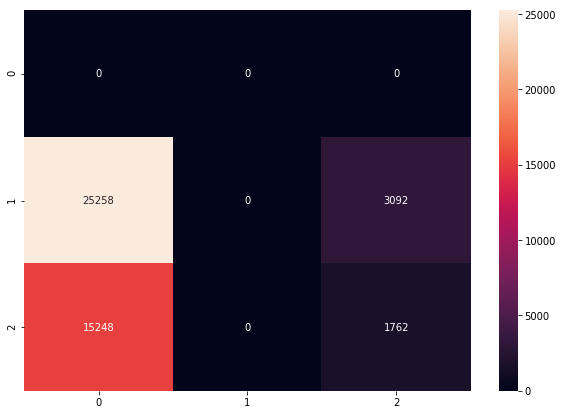

In [24]:
### plot confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

df_cm = pd.DataFrame(confusion_matrix(real_label, X_reduce['label']))
plt.figure(figsize=(10,7))
sn.heatmap(df_cm, annot=True, fmt='d')

In [ ]:
a = [1,2,3,4,5]

In [ ]:
idx_2

In [ ]:
real_label[idx_2].T

In [ ]:
train_dataset.iloc[16350:16360,:]